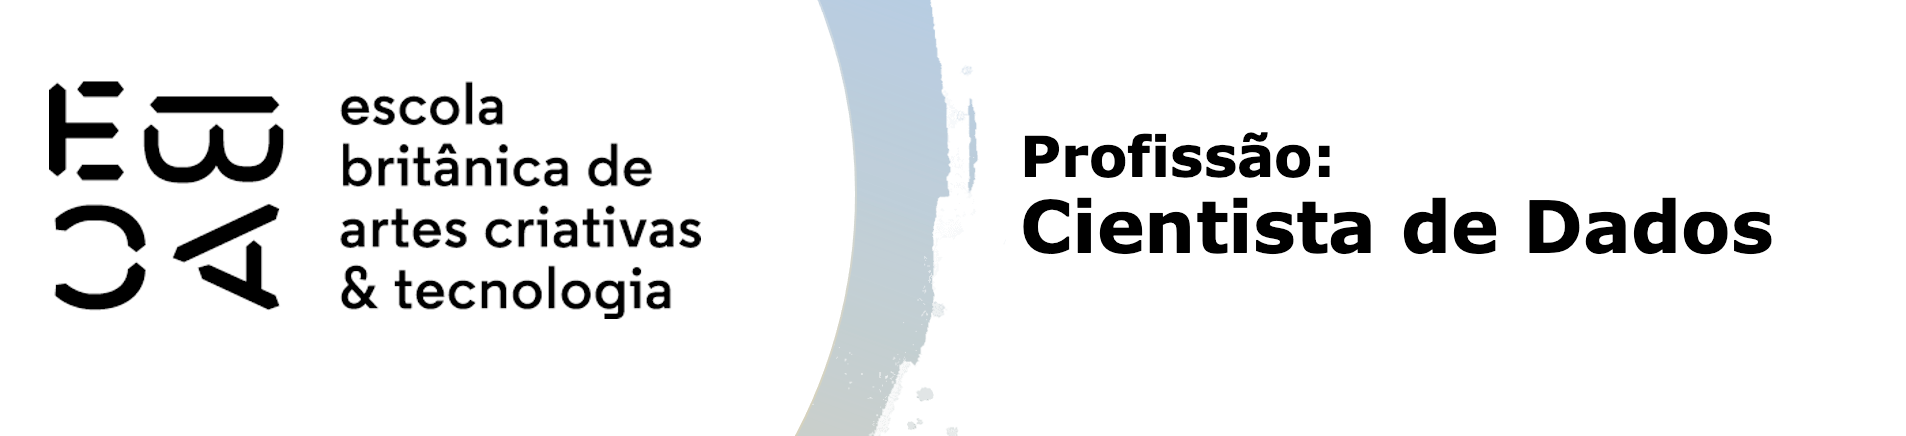

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr, chi2_contingency, f_oneway
from pycaret.classification import *

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

df = pd.read_feather('input/credit_scoring.ftr')
df.head()

RuntimeError: ('Pycaret only supports python 3.9, 3.10, 3.11. Your actual Python version: ', sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0), 'Please DOWNGRADE your Python version.')

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
print(df['data_ref'].min())
print(df['data_ref'].max())

2015-01-01 00:00:00
2016-03-01 00:00:00


In [3]:
df_train = df.set_index('data_ref')
df_train = df_train[:'2015-12-31'].reset_index()
df_valid = df.set_index('data_ref')
df_valid = df_valid['2016-01-01':].reset_index()

print('Conjunto de dados para modelagem (treino e teste): ' + str(df_train.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(df_valid.shape))

Conjunto de dados para modelagem (treino e teste): (600000, 15)
Conjunto de dados não usados no treino/teste, apenas como validação: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
linhas_por_mes = df_train.groupby(df_train['data_ref'].dt.to_period('M')).size()
print('Total de linhas : {}'.format(len(df_train)))
print('Linhas por mês : \n{}'.format(linhas_por_mes))

Total de linhas : 600000
Linhas por mês : 
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
Freq: M, dtype: int64


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [5]:
variaveis = list(df.columns)
variaveis = [var for var in variaveis if var not in ['index', 'data_ref']]
variaveis_quali = [var for var in variaveis if df[var].dtype == 'object']
variaveis_quant = [var for var in variaveis if df[var].dtype != 'object']

In [6]:
df_train[variaveis_quant].describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
count,600000.000000,600000.000000,499125.000000,600000.000000,6.000000e+05
mean,0.433210,43.798530,7.747992,2.212122,2.722284e+04
std,0.739869,11.230659,6.688576,0.903757,8.737788e+04
min,0.000000,22.000000,0.117808,1.000000,1.618600e+02
25%,0.000000,34.000000,3.049315,2.000000,4.670600e+03
50%,0.000000,43.000000,6.046575,2.000000,9.887580e+03
75%,1.000000,53.000000,10.180822,3.000000,2.162887e+04
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06


In [7]:
for var in variaveis_quali:
    print(f'\n{var}:')
    print(df_train[var].value_counts())


sexo:
sexo
F    403805
M    196195
Name: count, dtype: int64

posse_de_veiculo:
posse_de_veiculo
N    366293
S    233707
Name: count, dtype: int64

posse_de_imovel:
posse_de_imovel
S    403054
N    196946
Name: count, dtype: int64

tipo_renda:
tipo_renda
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: count, dtype: int64

educacao:
educacao
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: count, dtype: int64

estado_civil:
estado_civil
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: count, dtype: int64

tipo_residencia:
tipo_residencia
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: count, dtype: int64


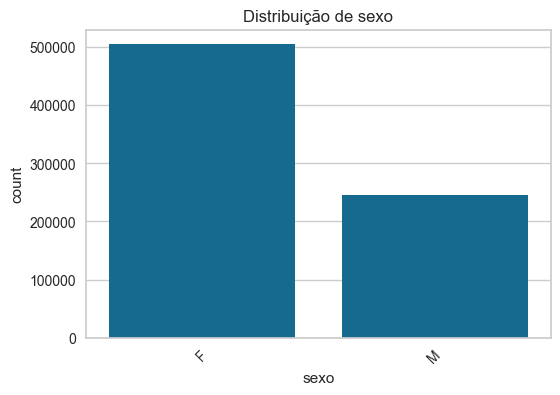

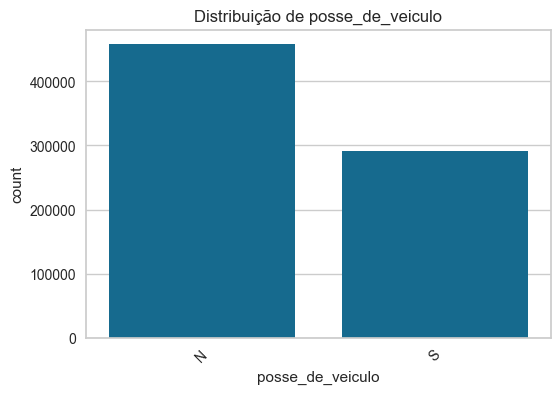

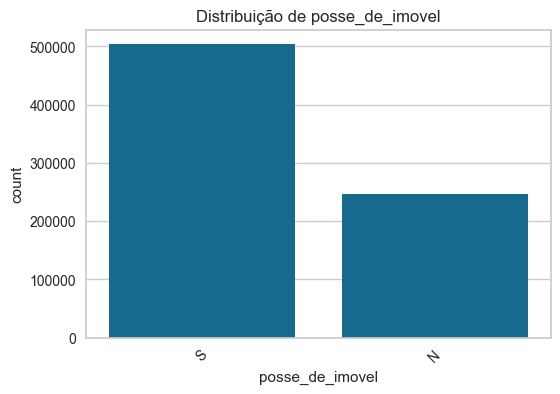

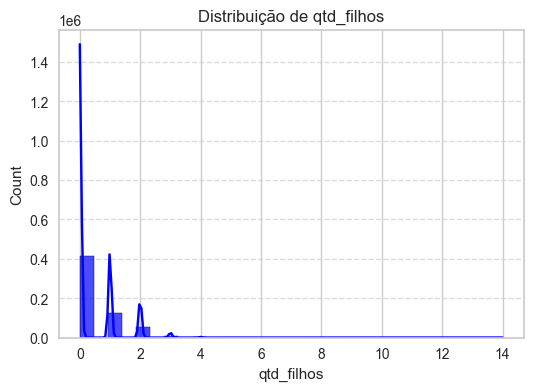

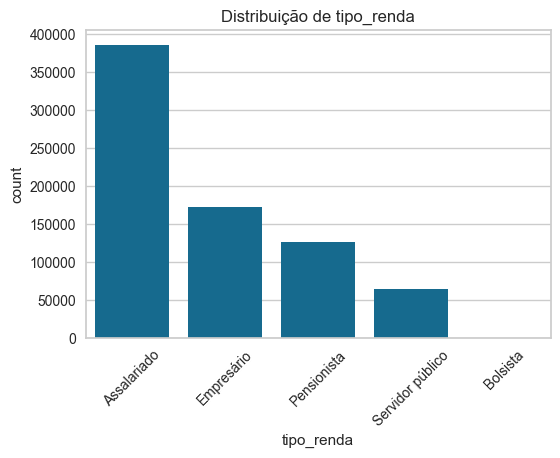

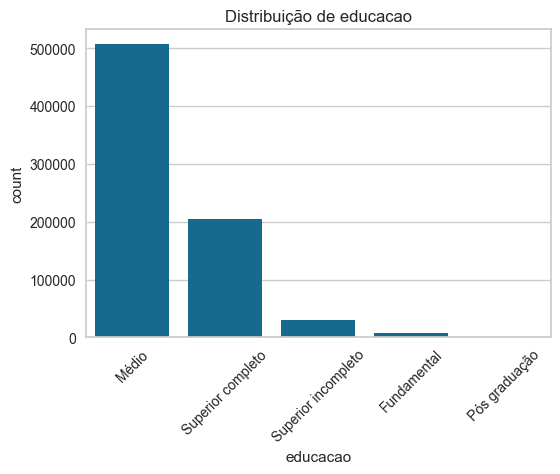

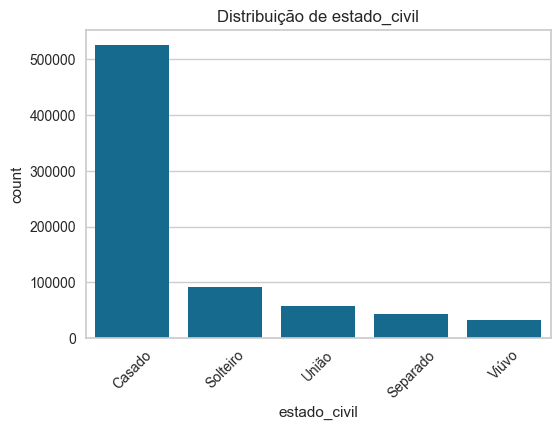

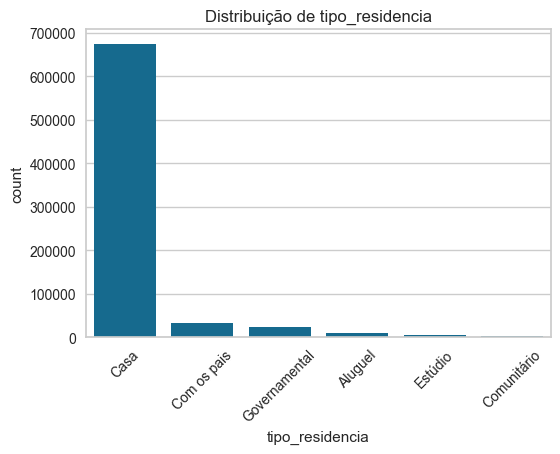

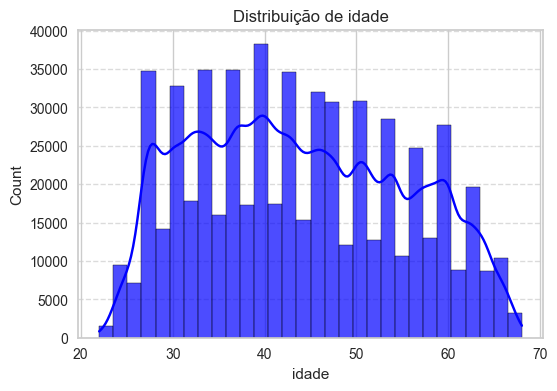

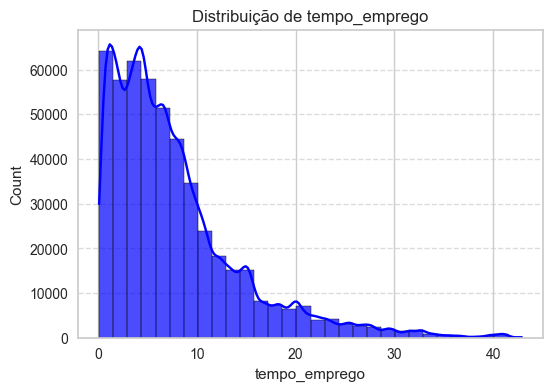

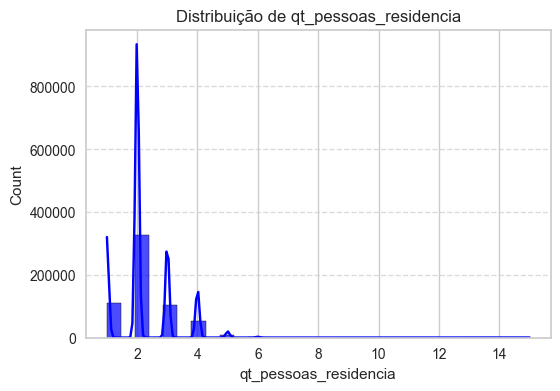

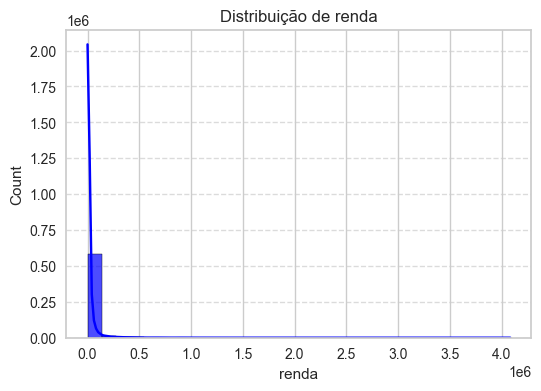

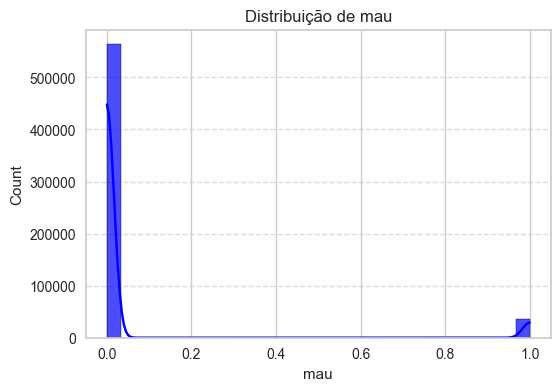

In [8]:
for var in variaveis:
        if df_train[var].dtype == 'object':
            plt.figure(figsize = (6 , 4))
            sns.countplot(data=df, x=var, order=df[var].value_counts().index)
            plt.title(f'Distribuição de {var}')
            plt.xticks(rotation = 45)
            plt.show()
        else:
            plt.figure(figsize = (6 , 4))
            plt.title(f'Distribuição de {var}')
            sns.histplot(df_train[var], kde=True, color='blue', bins=30, edgecolor='black', alpha=0.7)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

### Correlação de Pearson

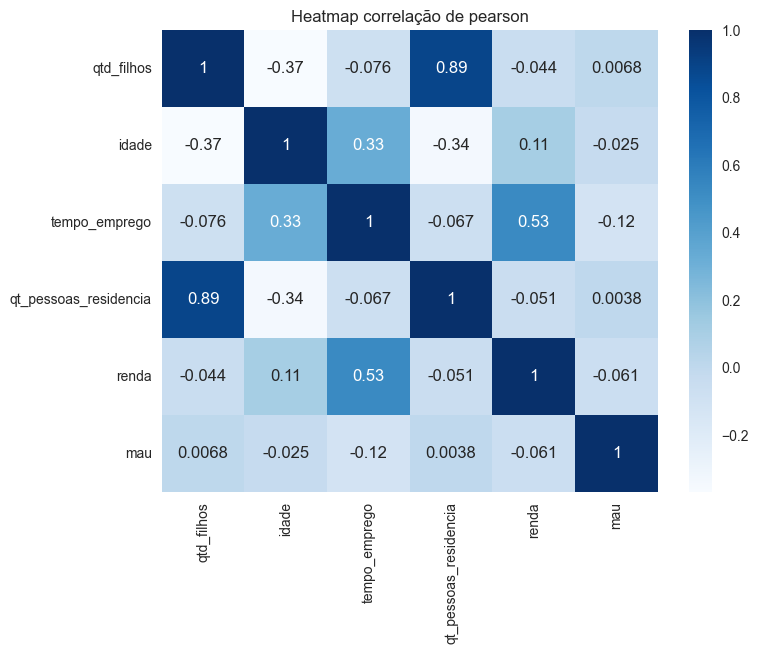

In [9]:
corr_pearson = df_train[variaveis_quant].corr()

plt.figure(figsize = (8 , 6))
sns.heatmap(data = corr_pearson , annot = True , cmap = 'Blues')
plt.title('Heatmap correlação de pearson')

plt.show()

### Correlação de Spearman

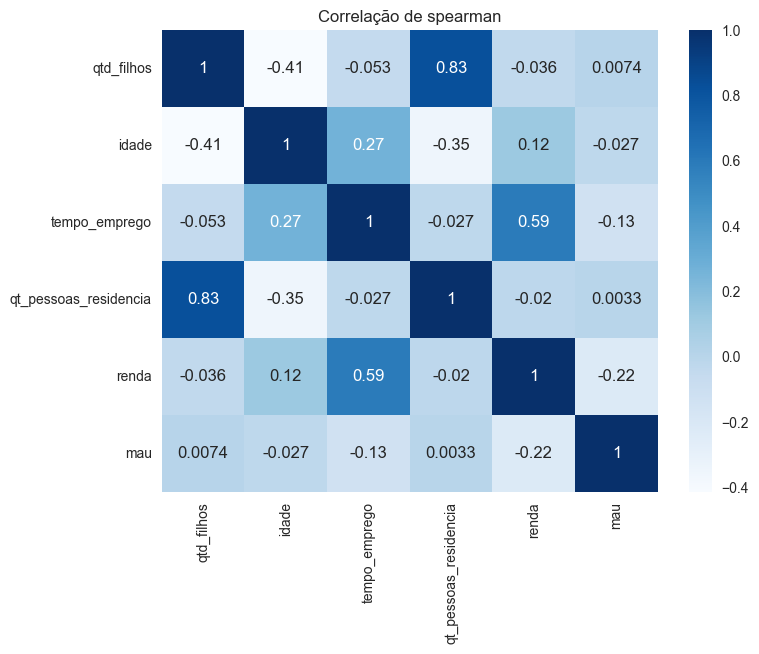

In [10]:
corr_spearman = df_train[variaveis_quant].corr(method = 'spearman')

plt.figure(figsize= (8 ,6))
plt.title('Correlação de spearman')

sns.heatmap(data = corr_spearman , annot = True , cmap = 'Blues')

plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [11]:
df_train['tempo_emprego'] = df_train['tempo_emprego'].fillna(0)
df_train.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Funções

In [12]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [13]:
def classificar_poder(iv):
    if pd.isnull(iv) or iv <= 0.02:
        return 'Inútil'
    elif iv <= 0.1:
        return 'Fraco'
    elif iv <= 0.3:
        return 'Médio'
    elif iv <= 0.5:
        return 'Forte'
    else:
        return 'Muito forte (Suspeito)'

In [14]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [15]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs , observed = True)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

### Metadados

In [16]:
metadados = pd.DataFrame(df_train[variaveis].dtypes , columns = ['dtypes'])
metadados['missings'] = df_train.isnull().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtypes,missings,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [17]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)

In [18]:
metadados['Class_IV'] = metadados['IV'].apply(classificar_poder)
metadados

,dtypes,missings,valores_unicos,papel,IV,Class_IV
sexo,object,0,2,covariavel,0.002665,Inútil
posse_de_veiculo,object,0,2,covariavel,0.000075,Inútil
posse_de_imovel,object,0,2,covariavel,0.009690,Inútil
qtd_filhos,int64,0,8,covariavel,0.000055,Inútil
tipo_renda,object,0,5,covariavel,0.009718,Inútil
educacao,object,0,5,covariavel,0.003690,Inútil
estado_civil,object,0,5,covariavel,0.001305,Inútil
tipo_residencia,object,0,6,covariavel,0.003330,Inútil
idade,int64,0,47,covariavel,0.018434,Inútil
tempo_emprego,float64,0,3005,covariavel,0.270820,Médio


,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


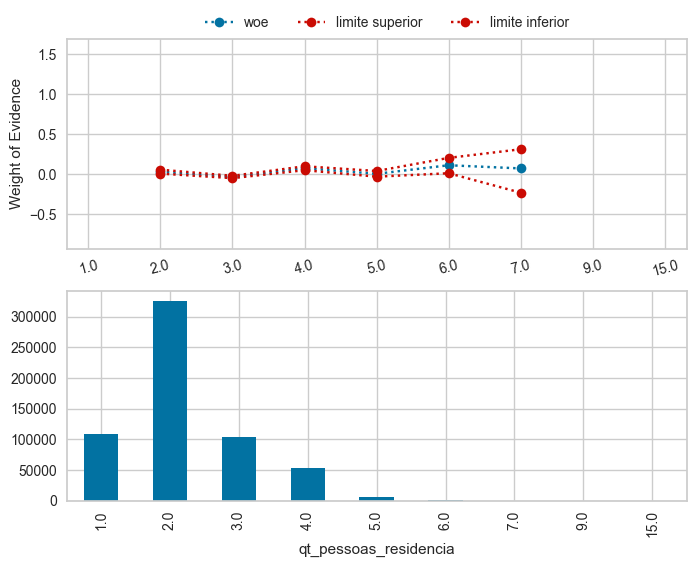

In [19]:
biv_discreta('qt_pessoas_residencia' , df_train)

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,105,7,0.062500,15.0,112,0.022873,0.107824,0.017176,-2.708050,-2.113166,-4.046899,0.024641,0.619525,-1.314208


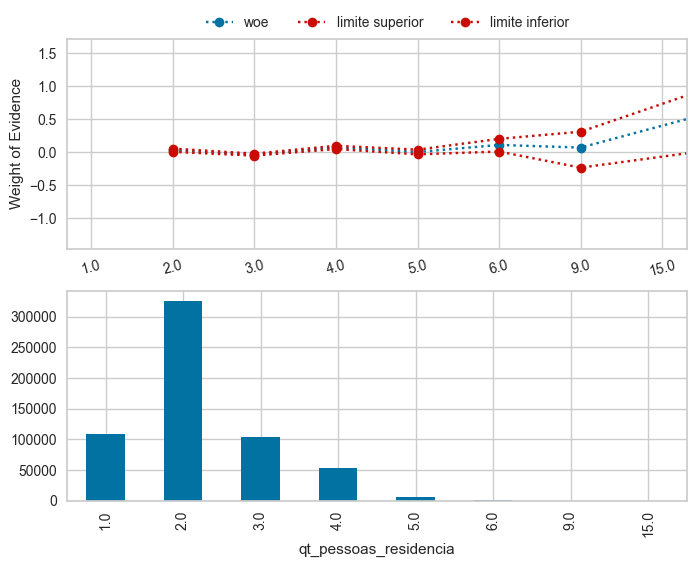

In [20]:
df_train2 = df_train.copy()
df_train2['qt_pessoas_residencia'] = df_train2['qt_pessoas_residencia'].replace({7: 15})
biv_discreta('qt_pessoas_residencia', df_train2)

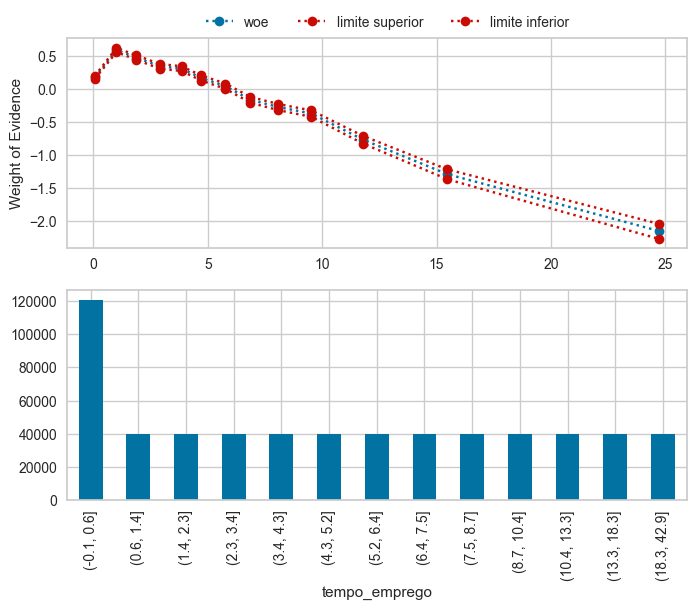

In [21]:
biv_continua('tempo_emprego' , 15 , df_train2)

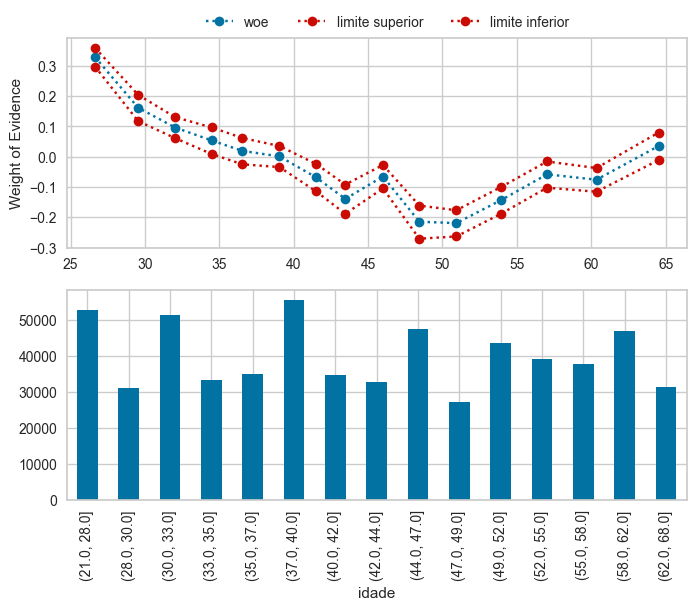

In [22]:
biv_continua('idade' , 15 , df_train2)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [23]:
metadados.sort_values('IV' , ascending = False)

,dtypes,missings,valores_unicos,papel,IV,Class_IV
renda,float64,0,112472,covariavel,0.959826,Muito forte (Suspeito)
tempo_emprego,float64,0,3005,covariavel,0.270820,Médio
idade,int64,0,47,covariavel,0.018434,Inútil
tipo_renda,object,0,5,covariavel,0.009718,Inútil
posse_de_imovel,object,0,2,covariavel,0.009690,Inútil
educacao,object,0,5,covariavel,0.003690,Inútil
tipo_residencia,object,0,6,covariavel,0.003330,Inútil
sexo,object,0,2,covariavel,0.002665,Inútil
estado_civil,object,0,5,covariavel,0.001305,Inútil
qt_pessoas_residencia,float64,0,9,covariavel,0.001263,Inútil


<font color='blue'>
Optei por incluir apneas as variaveis "tempo_emprego" , "idade" , "tipo_renda" , "posse_de_imovel"
<font>

In [24]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + sexo + estado_civil + qt_pessoas_residencia + posse_de_veiculo + qtd_filhos + mau'

In [25]:
formula = 'mau ~ tempo_emprego + idade + tipo_renda + posse_de_imovel'

In [26]:
rl = smf.glm(formula, data=df_train2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599992
Model Family:                         Binomial   Df Model:                            7
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.3288e+05
Date:                         Mon, 10 Mar 2025   Deviance:                   2.6576e+05
Time:                                 21:54:47   Pearson chi2:                 6.00e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.01674
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.7317      0.026     65.733      0.000       1.680       1.783
tipo_renda[T.Bolsista]            -0.2325      0.295     -0.788      0.431      -0.811       0.346
tipo_renda[T.Empresário]           0.1465      0.014     10.706      0.000       0.120       0.173
tipo_renda[T.Pensionista]          0.6555      0.021     30.701      0.000       0.614       0.697
tipo_renda[T.Servidor público]     0.1140      0.023      5.003      0.000       0.069       0.159
posse_de_imovel[T.S]               0.2101      0.011     18.444      0.000       0.188       0.232
tempo_emprego                      0.1239      0.002     80.555      0.000       0.121       0.127
idade                              0.0022      0.001      3.465      0.001       0.001       0.003
==================================================================================================
"""

In [27]:
df_train2['score'] = rl.predict(df_train2)

# Acurácia
acc_t = metrics.accuracy_score(df_train2.mau, df_train2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train2.mau, df_train2.score)
auc_t = metrics.auc(fpr, tpr)
#Gini
gini_t = 2*auc_t -1
ks_t = ks_2samp(df_train2.loc[df_train2.mau == 1, 'score'], df_train2.loc[df_train2.mau != 1, 'score']).statistic

In [28]:
df_valid['tempo_emprego'] = df_valid['tempo_emprego'].fillna(0)

In [29]:
rl = smf.glm(formula, data=df_valid, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               150000
Model:                                     GLM   Df Residuals:                   149992
Model Family:                         Binomial   Df Model:                            7
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:                -59616.
Date:                         Mon, 10 Mar 2025   Deviance:                   1.1923e+05
Time:                                 21:54:49   Pearson chi2:                 1.50e+05
No. Iterations:                              6   Pseudo R-squ. (CS):            0.03814
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.7098      0.036     19.563      0.000       0.639       0.781
tipo_renda[T.Bolsista]             0.7057      0.590      1.195      0.232      -0.451       1.863
tipo_renda[T.Empresário]           0.1307      0.019      7.000      0.000       0.094       0.167
tipo_renda[T.Pensionista]          0.6354      0.029     21.724      0.000       0.578       0.693
tipo_renda[T.Servidor público]     0.0956      0.031      3.128      0.002       0.036       0.155
posse_de_imovel[T.S]               0.2213      0.016     14.153      0.000       0.191       0.252
tempo_emprego                      0.1238      0.002     61.093      0.000       0.120       0.128
idade                              0.0028      0.001      3.258      0.001       0.001       0.005
==================================================================================================
"""

In [30]:
df_valid['score'] = rl.predict(df_valid)

# Acurácia
acc_d = metrics.accuracy_score(df_valid.mau, df_valid.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_valid.mau, df_valid.score)
auc_d = metrics.auc(fpr, tpr)
#Gini
gini_d = 2*auc_t -1
ks_d = ks_2samp(df_valid.loc[df_valid.mau == 1, 'score'], df_valid.loc[df_valid.mau != 1, 'score']).statistic

print('Avaliação base de treino: \n\nAcurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc_t, auc_t, gini_t, ks_t))

print('\nAvaliação base de desenvolvimento:\n\nAcurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc_d, auc_d, gini_d, ks_d))

Avaliação base de treino: 

Acurácia: 6.1% 
AUC: 35.6% 
GINI: -28.8%
KS: 19.8%

Avaliação base de desenvolvimento:

Acurácia: 14.7% 
AUC: 35.3% 
GINI: -28.8%
KS: 20.3%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [31]:
df.isnull().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [32]:
df_copy = df.copy()
df_copy['tempo_emprego'] = df_copy['tempo_emprego'].fillna(df_copy['tempo_emprego'].mean())

In [33]:
df_copy.isnull().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [34]:
def outliers_zscore(data, threshold=3):   
    z_scores = np.abs(stats.zscore(data))
    return (z_scores > threshold)

In [35]:
outliers_mask = outliers_zscore(df_copy['tempo_emprego'])
outliers_mask.value_counts()

tempo_emprego
False    733702
True      16298
Name: count, dtype: int64

In [36]:
print(df_copy.loc[outliers_mask , 'tempo_emprego'])

220       36.865753
277       41.200000
345       27.654795
374       33.786301
381       30.117808
            ...    
749469    28.739726
749512    29.961644
749749    29.534247
749813    38.405479
749869    35.142466
Name: tempo_emprego, Length: 16298, dtype: float64


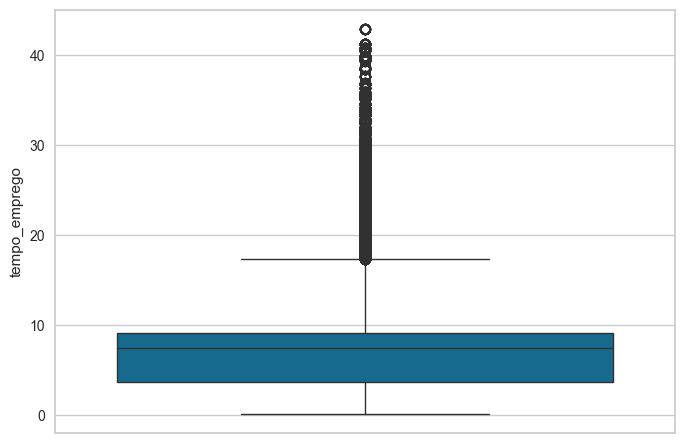

In [37]:
sns.boxplot(df_copy['tempo_emprego']);

In [38]:
df_copy.loc[outliers_mask, ['tempo_emprego', 'idade']].mean()

tempo_emprego    31.234755
idade            53.350472
dtype: float64

<font color='blue'>
Decidi não excluir os outliers, pois a média do tempo de emprego elevado corresponde a pessoas com idade acima de 50 anos. Esse comportamento é esperado, já que indivíduos mais velhos tendem a ter um histórico de emprego mais longo.
<font>

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [39]:
df_amostra = df_copy.sample(n = 75000 , random_state= 21)
y_amostra = df_amostra['mau']
x_amostra = df_amostra.drop(columns = ['mau' , 'data_ref' , 'index'] , axis = 1)
x_amostra = pd.get_dummies(x_amostra , drop_first= True)

In [40]:
rf = RandomForestClassifier(n_estimators= 100 , random_state= 21)

In [41]:
rm = RandomForestClassifier()
rm.fit(x_amostra , y_amostra)

RandomForestClassifier()

In [42]:
importancia = rm.feature_importances_
indices = importancia.argsort()[::-1]
variaveis_names = x_amostra.columns

Ranking das variáveis:
1. renda (0.6136)
2. tempo_emprego (0.1287)
3. idade (0.1139)
4. qt_pessoas_residencia (0.0185)
5. posse_de_veiculo_S (0.0155)
6. qtd_filhos (0.0135)
7. sexo_M (0.0123)
8. tipo_renda_Empresário (0.0113)
9. posse_de_imovel_S (0.0110)
10. estado_civil_União (0.0083)
11. educacao_Médio (0.0074)
12. educacao_Superior completo (0.0067)
13. estado_civil_Solteiro (0.0066)
14. tipo_renda_Servidor público (0.0059)
15. tipo_residencia_Casa (0.0053)
16. estado_civil_Separado (0.0049)
17. educacao_Superior incompleto (0.0034)
18. tipo_residencia_Com os pais (0.0031)
19. tipo_renda_Pensionista (0.0028)
20. tipo_residencia_Governamental (0.0028)
21. estado_civil_Viúvo (0.0026)
22. tipo_residencia_Estúdio (0.0010)
23. tipo_residencia_Comunitário (0.0005)
24. educacao_Pós graduação (0.0003)
25. tipo_renda_Bolsista (0.0000)


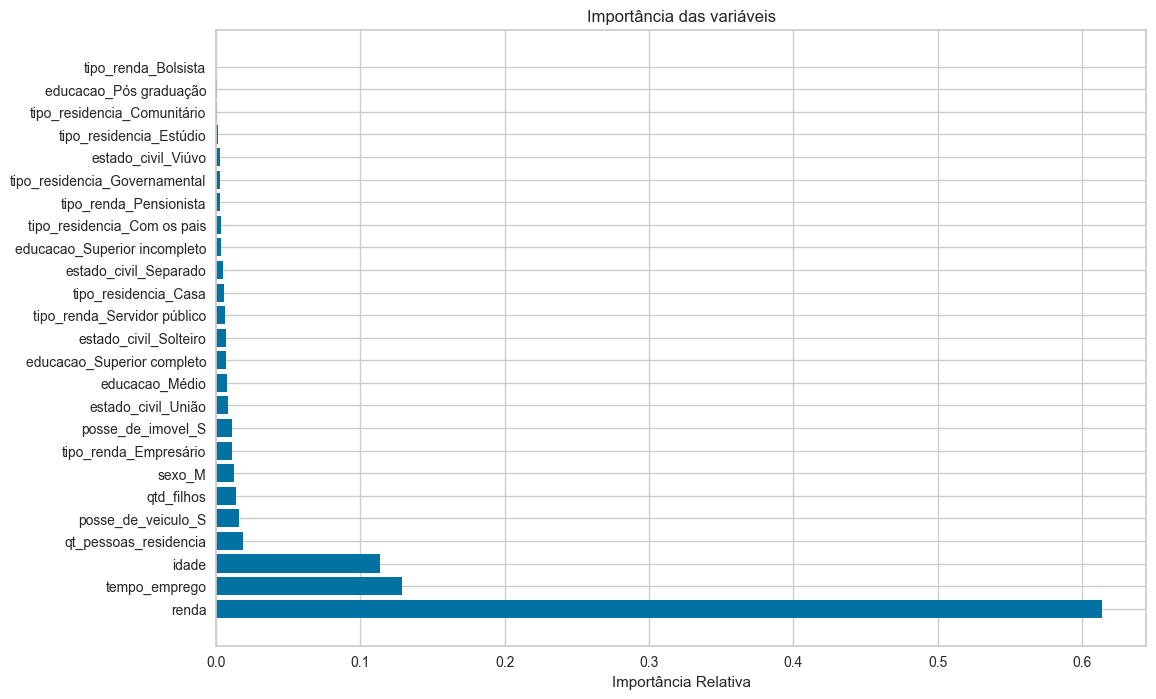

In [43]:
print("Ranking das variáveis:")
for i in range(x_amostra.shape[1]):
    print(f"{i + 1}. {variaveis_names[indices[i]]} ({importancia[indices[i]]:.4f})")

plt.figure(figsize=(12, 8))
plt.title("Importância das variáveis")
plt.barh(range(x_amostra.shape[1]), importancia[indices], align='center')
plt.yticks(range(x_amostra.shape[1]), [variaveis_names[i] for i in indices])
plt.xlabel("Importância Relativa")
plt.show()

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [44]:
#padronizar os dados
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_amostra)

#pca para 5 componentes
pca = PCA(n_components= 5)
x_pca = pca.fit_transform(x_scaled)

#variancia explicada
explained_variance = pca.explained_variance_ratio_

print(f"Variância explicada por cada componente: {explained_variance}")
print(f"Variância total explicada: {sum(explained_variance)*100:.2f}%")

Variância explicada por cada componente: [0.11904602 0.07857654 0.0767558  0.06461492 0.05562663]
Variância total explicada: 39.46%


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

<font color='blue'>
Criação de dummies já foi aplicada
<font>

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [45]:
X = df_amostra.drop(columns= ['data_ref' , 'mau' , 'index'] , axis = 1)
y = df_amostra['mau']
X_train , x_test , y_train , y_test = train_test_split(X , y , random_state=21 , test_size= 0.2)

In [46]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])
                
quali_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputando valores faltantes
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # Codificando variáveis categóricas
])

pca = PCA(n_components= 5)

In [47]:
variaveis_quant.remove('mau')

In [48]:
preprocessor = ColumnTransformer(transformers=[
    ('num' , num_transformer , variaveis_quant),
    ('quali' , quali_transformer , variaveis_quali)
])

In [49]:
pipe = Pipeline(steps = [('preprocessor' , preprocessor),
                        ('pca' , pca),
                        ('Classifier' , LogisticRegression())])

In [50]:
pipe.fit(X_train , y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['qtd_filhos', 'idade',
                                                   'tempo_emprego',
                                                   'qt_pessoas_residencia',
                                                   'renda']),
                                                 ('quali',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])])),
                ('pca', PCA(n_components=5)),
                ('Classifier', LogisticRegression())])

In [51]:
y_pred = pipe.predict(x_test)

In [52]:
acuracia = accuracy_score(y_pred , y_test)
acuracia

0.9218666666666666

In [53]:
pipe.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['qtd_filhos', 'idade', 'tempo_emprego',
                                   'qt_pessoas_residencia', 'renda']),
                                 ('quali',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                                   'tipo_renda', 'educacao', 'estado_civil',
                                   'tipo_residencia'])]),
 'pca': PCA(n_components=5),
 'Classifier': LogisticRegression()

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [130]:
df_train_test = df.sample(frac=0.95, random_state= 21)
df_unseen = df.drop(df_train_test.index)

df_train_test.reset_index(inplace=True, drop=True)
df_unseen.reset_index(inplace=True, drop=True)

print('Conjunto de dados para modelagem (treino e teste): ' + str(df_train_test.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(df_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 15)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 15)


In [131]:
df_train_test = df_train_test.drop(columns= ['data_ref' , 'index'])
df_train_test.qtd_filhos = df_train_test.qtd_filhos.astype('float')
df_train_test['tempo_emprego'] = df_train_test['tempo_emprego'].fillna(df_train_test['tempo_emprego'].mean())

df_unseen = df_unseen.drop(columns= ['data_ref' , 'index'])
df_unseen.qtd_filhos = df_unseen.qtd_filhos.astype('float')
df_unseen['tempo_emprego'] = df_unseen['tempo_emprego'].fillna(df_unseen['tempo_emprego'].mean())


In [119]:
df_train_test.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos               float64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [115]:
df_train_test.mau.value_counts()

mau
False    656820
True      55680
Name: count, dtype: int64

In [87]:
s = setup(data = df_train_test , target = 'mau' , session_id= 21)

,Description,Value
0,Session id,21
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 13)"
4,Transformed data shape,"(712500, 30)"
5,Transformed train set shape,"(498749, 30)"
6,Transformed test set shape,"(213751, 30)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


In [90]:
%%time
lgb = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9222,0.7802,0.0236,0.5542,0.0453,0.0392,0.1025
1,0.9222,0.7875,0.0239,0.5536,0.0458,0.0396,0.1030
2,0.9221,0.7854,0.0234,0.5291,0.0447,0.0384,0.0988
3,0.9221,0.7826,0.0257,0.5348,0.0490,0.0421,0.1044
4,0.9220,0.7818,0.0239,0.5284,0.0457,0.0392,0.0998
5,0.9219,0.7809,0.0215,0.5060,0.0413,0.0352,0.0921
6,0.9221,0.7780,0.0274,0.5350,0.0522,0.0449,0.1080
7,0.9223,0.7811,0.0257,0.5618,0.0491,0.0425,0.1078
8,0.9222,0.7818,0.0236,0.5542,0.0453,0.0391,0.1025


In [92]:
%%time
tuned_lgb = tune_model(lgb , optimize= 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7689,0.0298,0.4957,0.0562,0.0477,0.1068
1,0.9222,0.7741,0.0331,0.5375,0.0624,0.0538,0.1190
2,0.9216,0.7686,0.0318,0.4788,0.0597,0.0504,0.1079
3,0.9220,0.7708,0.0334,0.5159,0.0627,0.0537,0.1162
4,0.9219,0.7728,0.0321,0.5040,0.0603,0.0514,0.1122
5,0.9216,0.7690,0.0298,0.4754,0.0560,0.0472,0.1038
6,0.9217,0.7675,0.0298,0.4833,0.0561,0.0474,0.1050
7,0.9219,0.7677,0.0328,0.5039,0.0617,0.0526,0.1135
8,0.9219,0.7725,0.0305,0.5042,0.0576,0.0491,0.1095


Fitting 10 folds for each of 10 candidates, totalling 100 fits
CPU times: total: 46.3 s
Wall time: 5min 10s


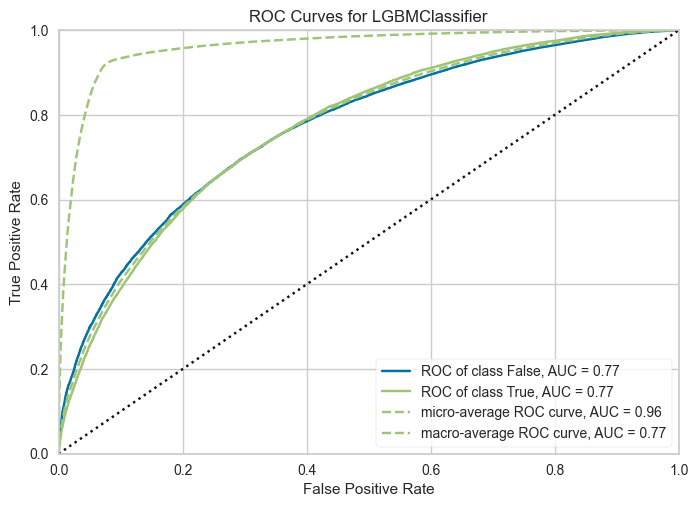

In [95]:
plot_model(tuned_lgb , plot = 'auc')

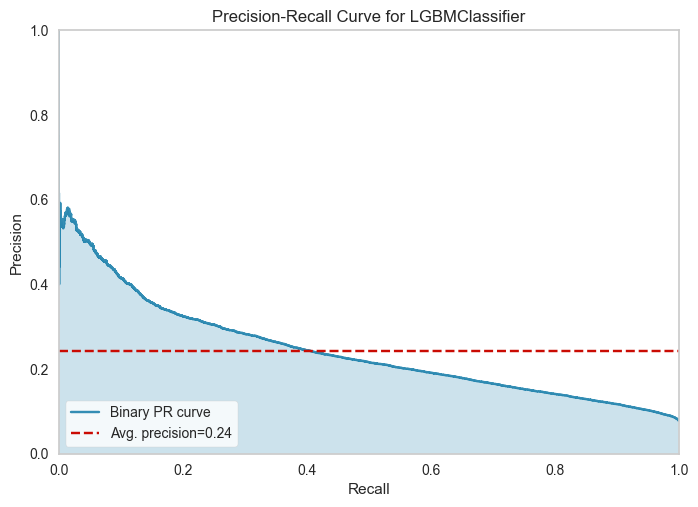

In [97]:
plot_model(tuned_lgb , plot = 'pr')

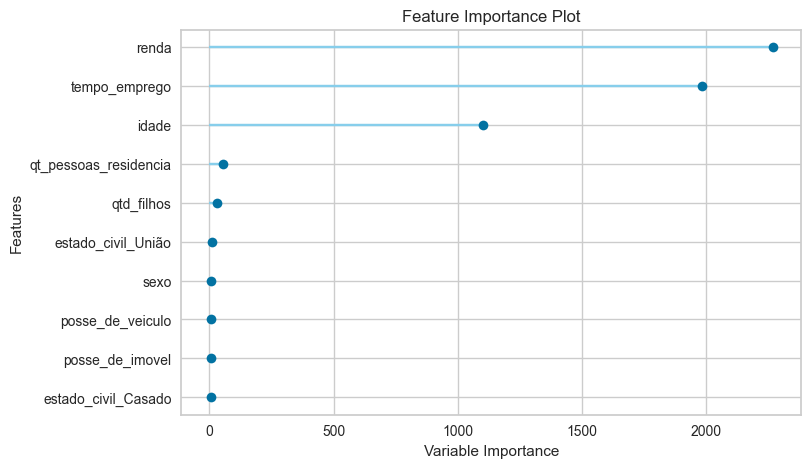

In [99]:
plot_model(tuned_lgb , plot = 'feature')

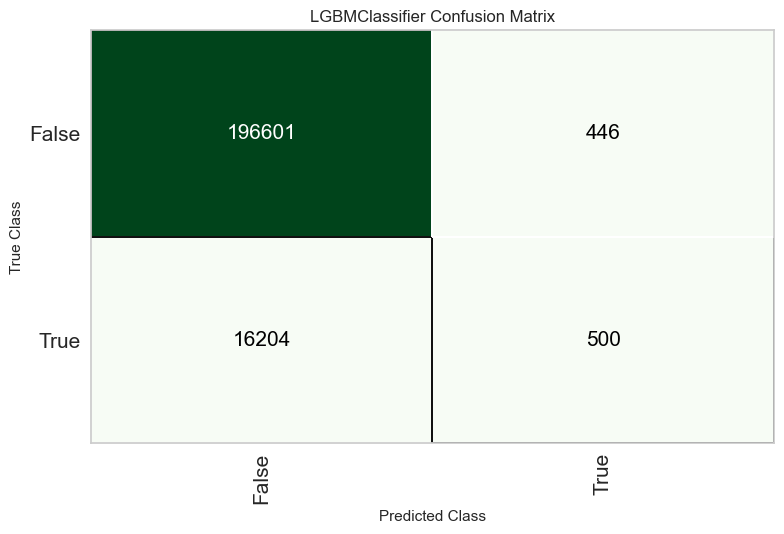

In [100]:
plot_model(tuned_lgb , plot = 'confusion_matrix')

In [101]:
evaluate_model(tuned_lgb)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [135]:
unseen_predict = predict_model(tuned_lgb , data= df_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9211,0.7666,0.0300,0.5086,0.0567,0.0483,0.1090


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [140]:
save_model(tuned_lgb, 'lightgbm_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            